<a href="https://colab.research.google.com/github/luciaeveberger/data_science_final_project/blob/model_dev_exploration/Kaggle10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2
from tensorflow.keras import regularizers
from keras.layers import Dropout
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import dateutil

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
def pre_process(data):
  # User Name column is not relevent
  data.drop('User Name', 1,inplace=True)

  # Replacing null with 0 and non-null with 1
  data['Personal URL'] = data['Personal URL'].notnull().astype('int')

  # Set --> 1 and not Set --> 0
  data['Profile Cover Image Status'] = np.where(data['Profile Cover Image Status']=='Set', 1, 0)

  # One-Hot encoding for Profile Verification Status column
  #data = pd.get_dummies(data, columns = ['Profile Verification Status'])


  #Frequnce encoding for Profile Verification Status column
  enc_prof_verif = (data.groupby('Profile Verification Status').size()) / len(data)
  data['Profile Verification Status'] = data['Profile Verification Status'].apply(lambda x : enc_prof_verif[x])

  #Frequnce encoding for Color columns
  data['Profile Theme Color'].fillna(0,inplace = True)
  enc_color_theme = (data.groupby('Profile Theme Color').size()) / len(data)
  data['Profile Theme Color'] = data['Profile Theme Color'].apply(lambda x : enc_color_theme[x])
  data['Profile Text Color'].fillna(0,inplace = True)
  enc_color_text = (data.groupby('Profile Text Color').size()) / len(data)
  data['Profile Text Color'] = data['Profile Text Color'].apply(lambda x : enc_color_text[x])
  data['Profile Page Color'].fillna(0,inplace = True)
  enc_color_page = (data.groupby('Profile Page Color').size()) / len(data)
  data['Profile Page Color'] = data['Profile Page Color'].apply(lambda x : enc_color_page[x])

  # Mapping True/False --> 1/0
  data['Is Profile View Size Customized?'] = data['Is Profile View Size Customized?'].astype(int)

  # Dropping irrelevant Cols (Maybe we should use them)
  data.drop(['UTC Offset', 'Location'], axis=1, inplace=True)

  # Enabled --> 1 and Disabled or ??? --> 0
  data['Location Public Visibility'] = np.where(data['Location Public Visibility'].str.lower() == 'enabled', 1, 0)

  # Frequency encoding for user language
  enc_user_lang = (data.groupby('User Language').size()) / len(data)
  data['User Language'] = data['User Language'].apply(lambda x : enc_user_lang[x])

  # Frequency encoding for User time zone
  data['User Time Zone'].fillna(data['User Time Zone'].value_counts().index[0],inplace = True)
  enc_time_zone = (data.groupby('User Time Zone').size()) / len(data)
  data['User Time Zone'] = data['User Time Zone'].apply(lambda x : enc_time_zone[x])

  # Replacing the white spaces with nan
  data['Profile Category'] = data['Profile Category'].replace(r'^\s*$', np.nan, regex=True)
  # Replacing nan with 'unknown'
  data['Profile Category'].fillna('unknown',inplace = True)

  # One-hot encoding
  #data = pd.get_dummies(data, columns = ['Profile Category'])

  # Frequency encoding for profile category
  enc_prof_cat = (data.groupby('Profile Category').size()) / len(data)
  data['Profile Category'] = data['Profile Category'].apply(lambda x : enc_prof_cat[x])


  # Median imputation for 'Avg Daily Profile Clicks'And'Avg Daily Profile Visit Duration in seconds'
  imp_median = SimpleImputer( strategy='median') #for median imputation replace 'mean' with 'median'
  imp_median.fit(data[['Avg Daily Profile Clicks','Avg Daily Profile Visit Duration in seconds']])
  imputed_train_df = imp_median.transform(data[['Avg Daily Profile Clicks','Avg Daily Profile Visit Duration in seconds']])
  imputed_train_df = pd.DataFrame(imputed_train_df,columns=['Avg Daily Profile Clicks','Avg Daily Profile Visit Duration in seconds'])
  data[['Avg Daily Profile Clicks','Avg Daily Profile Visit Duration in seconds']] = imputed_train_df[['Avg Daily Profile Clicks','Avg Daily Profile Visit Duration in seconds']]

  # Removing Outliers
  # Q1 = data['Num of Followers'].quantile(0.25)
  # Q3 = data['Num of Followers'].quantile(0.75)
  # IQR = Q3 - Q1
  # Q3 + 1.5 * IQR
  # data = data[data['Num of Followers'] <(Q3 + 1.5 * IQR)]

  # Making Id column as index
  data.set_index('Id',inplace=True)

  # Dropping Pic Col for now
  data.drop('Profile Image', 1,inplace=True)
  # Dropping Personal Url column
  #data.drop('Personal URL', 1,inplace=True)

  #Parsing Number of years until 2020
  data['Profile Creation Timestamp'] = data['Profile Creation Timestamp'].apply(lambda x: dateutil.parser.parse(x))
  data['Profile Creation Timestamp']=pd.DatetimeIndex(data['Profile Creation Timestamp']).year
  data['Profile Creation Timestamp'] = 2020-data['Profile Creation Timestamp']

  return data




In [8]:
df_train = pre_process(pd.read_csv("/content/gdrive/MyDrive/ift6758-a20/train.csv"))
df_test = pre_process(pd.read_csv("/content/gdrive/MyDrive/ift6758-a20/test.csv")) 

In [9]:
y_col = ['Num of Profile Likes']
x_col = df_train.columns.difference(['Num of Profile Likes'])

In [10]:
#Standardization - Train
df_train_stand = df_train.copy()
for i in x_col:
    
    # fit on training data column
    scale = StandardScaler().fit(df_train_stand[[i]])
    
    # transform the training data column
    df_train_stand[i] = scale.transform(df_train_stand[[i]])

In [11]:
#Standardization - Test
df_test_stand = df_test.copy()
for i in x_col:
    
    # fit on training data column
    scale = StandardScaler().fit(df_test_stand[[i]])
    
    # transform the training data column
    df_test_stand[i] = scale.transform(df_test_stand[[i]])

In [12]:
# pearson's correlation feature selection 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# define feature selection
fs = SelectKBest(score_func=f_regression, k='all')
# apply feature selection
X_selected = fs.fit_transform(df_train_stand[x_col], df_train_stand[y_col].values.ravel())
names = df_train_stand[x_col].columns.values[fs.get_support()]
scores = fs.scores_[fs.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

                                     Feat_names    F_Scores
8                                  Personal URL  210.237773
0                      Avg Daily Profile Clicks  162.683265
9                              Profile Category  133.397593
6                       Num of People Following  115.705358
15                  Profile Verification Status   67.559534
3                    Location Public Visibility   43.336782
11                   Profile Creation Timestamp   28.172260
12                           Profile Page Color   26.618781
2              Is Profile View Size Customized?   18.128637
7                         Num of Status Updates   14.007676
13                           Profile Text Color   10.973332
17                               User Time Zone    9.846833
14                          Profile Theme Color    8.691975
16                                User Language    2.251782
1   Avg Daily Profile Visit Duration in seconds    1.257316
5                              Num of Fo

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [37]:
input_width = 22

In [38]:


num_features = df_train_stand[x_col].shape[1]
model = Sequential()
model.add(Dense(input_width, activation='relu', input_dim=num_features))
model.add(Dense(input_width, activation='relu'))
model.add(Dense(22, activation='relu'))
#
model.add(Dense(1, activation='linear'))


In [39]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 22)                418       
_________________________________________________________________
dense_22 (Dense)             (None, 22)                506       
_________________________________________________________________
dense_23 (Dense)             (None, 22)                506       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 23        
Total params: 1,453
Trainable params: 1,453
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 20
model.compile(optimizer='adam', loss='mean_squared_logarithmic_error', metrics='mean_squared_logarithmic_error')
history = model.fit(df_train_stand[x_col], df_train_stand[y_col], batch_size=batch_size, epochs=100,validation_split=0.3)

Epoch 1/100
263/263 [==============================] - 1s 2ms/step - loss: 24.4278 - mean_squared_logarithmic_error: 24.4278 - val_loss: 12.1386 - val_mean_squared_logarithmic_error: 12.1386
Epoch 2/100
263/263 [==============================] - 0s 2ms/step - loss: 9.0649 - mean_squared_logarithmic_error: 9.0649 - val_loss: 7.4647 - val_mean_squared_logarithmic_error: 7.4647
Epoch 3/100
263/263 [==============================] - 0s 2ms/step - loss: 6.3028 - mean_squared_logarithmic_error: 6.3028 - val_loss: 6.0370 - val_mean_squared_logarithmic_error: 6.0370
Epoch 4/100
263/263 [==============================] - 0s 2ms/step - loss: 5.2874 - mean_squared_logarithmic_error: 5.2874 - val_loss: 5.3844 - val_mean_squared_logarithmic_error: 5.3844
Epoch 5/100
263/263 [==============================] - 0s 2ms/step - loss: 4.7652 - mean_squared_logarithmic_error: 4.7652 - val_loss: 4.9981 - val_mean_squared_logarithmic_error: 4.9981
Epoch 6/100
263/263 [==============================] - 0s 2ms

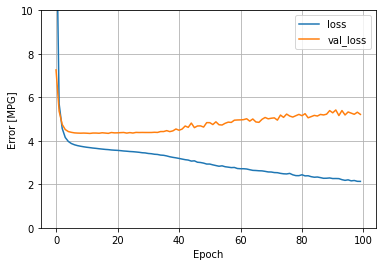

In [35]:
plot_loss(history)

In [22]:
# Submission file
y_pred = model.predict(df_test_stand[x_col])
dummy = pd.DataFrame()
dummy["Id"] = df_test.index
dummy["Predicted"]=y_pred
dummy.to_csv("submission.csv", sep=',' ,index=False)
len(y_pred)

2500